In [51]:
import xarray as xr
import glob
import os
import regex as re
import matplotlib.pyplot as plt
import pandas as pd
from dask.diagnostics import ProgressBar
import dask

In [38]:
rootdir = '/scratch/gpfs/graemem/'
rootdir_era5 = rootdir+'era5/reanalysis-era5-single-levels-monthly-means/monthly_averaged_reanalysis/global/annual/'
rootdir_sos = '/scratch/gpfs/graemem/en4/EN.4.2.2_regridded/'
rootdir_wmt = rootdir+'era5_wmt/'
ppname = 'era5.monthly_averaged_reanalysis'
year = '*'
filename = ppname+'.'+str(year)+'.*.nc'
pathstr = rootdir_era5+str(year)+'/'+filename
paths = glob.glob(pathstr)
paths[0]

'/scratch/gpfs/graemem/era5/reanalysis-era5-single-levels-monthly-means/monthly_averaged_reanalysis/global/annual/1968/era5.monthly_averaged_reanalysis.1968.surface_sensible_heat_flux.nc'

In [39]:
# Grab only the paths for the variables of interest
variables = ['sea_surface_temperature',
             'mean_evaporation_rate','mean_total_precipitation_rate','mean_surface_runoff_rate',
             'mean_surface_sensible_heat_flux','mean_surface_latent_heat_flux',
             'mean_surface_net_long_wave_radiation_flux','mean_surface_net_short_wave_radiation_flux']
reg = re.compile(r"\L<variables>", variables=variables)
pathsnow = list(filter(reg.search, paths))

In [40]:
pathsnow[0]

'/scratch/gpfs/graemem/era5/reanalysis-era5-single-levels-monthly-means/monthly_averaged_reanalysis/global/annual/1968/era5.monthly_averaged_reanalysis.1968.mean_evaporation_rate.nc'

In [52]:
ds = xr.open_mfdataset(pathsnow)
ds = ds.rename({'latitude':'lat','longitude':'lon'})
with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ds = ds.chunk({'time':24}).sortby('lat')

In [53]:
ds

<xarray.Dataset>
Dimensions:  (lon: 1440, lat: 721, time: 756)
Coordinates:
  * lon      (lon) float32 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
  * lat      (lat) float32 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75 90.0
  * time     (time) datetime64[ns] 1959-01-01 1959-02-01 ... 2021-12-01
Data variables:
    mer      (time, lat, lon) float32 dask.array<chunksize=(24, 721, 1440), meta=np.ndarray>
    mslhf    (time, lat, lon) float32 dask.array<chunksize=(24, 721, 1440), meta=np.ndarray>
    msnlwrf  (time, lat, lon) float32 dask.array<chunksize=(24, 721, 1440), meta=np.ndarray>
    msnswrf  (time, lat, lon) float32 dask.array<chunksize=(24, 721, 1440), meta=np.ndarray>
    msror    (time, lat, lon) float32 dask.array<chunksize=(24, 721, 1440), meta=np.ndarray>
    msshf    (time, lat, lon) float32 dask.array<chunksize=(24, 721, 1440), meta=np.ndarray>
    mtpr     (time, lat, lon) float32 dask.array<chunksize=(24, 721, 1440), meta=np.ndarray>
    sst      (time, lat, lon) float32 dask.array<chunksize=(24, 721, 1440), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2022-07-16 22:24:52 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

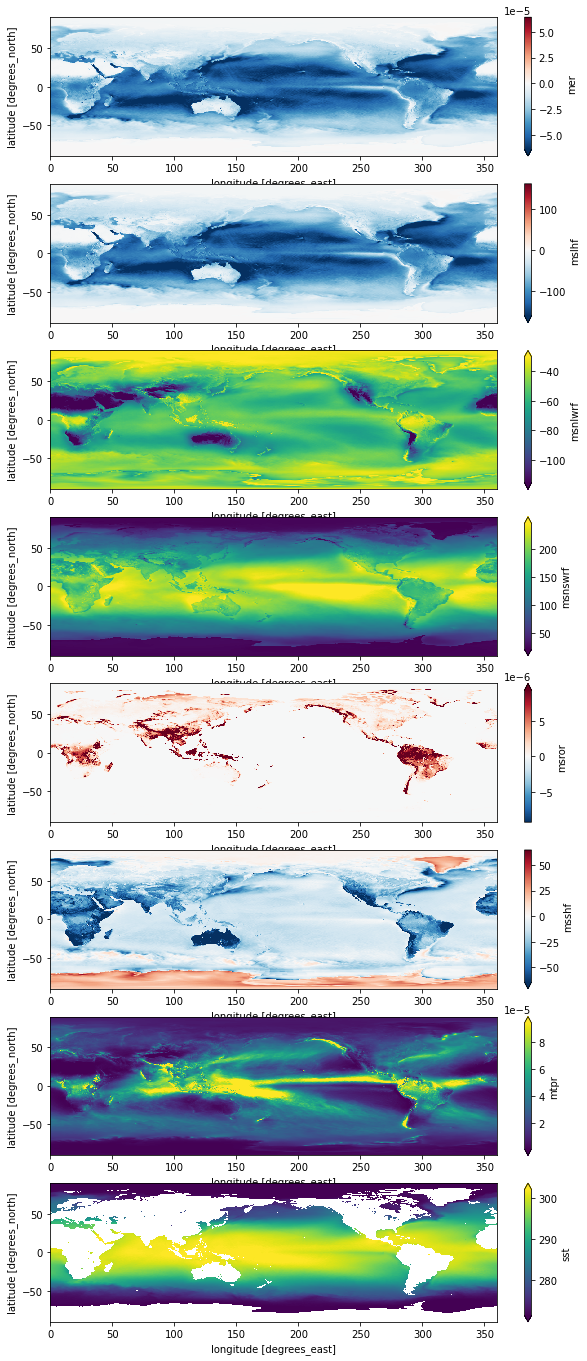

In [55]:
nv = len(ds.data_vars)
fig,axarr = plt.subplots(figsize=(10,3*nv),nrows=nv)
for i,variable in enumerate(ds.data_vars):
    ax = axarr.flat[i]
    da = ds[variable].isel(time=slice(0,24)).mean('time')
    da.plot(ax=ax,robust=True)

In [56]:
ds_wmt = xr.Dataset()
# Calculate terms
ds_wmt['tos'] = ds['sst']-273.15 # Mask out under-ice
ds_wmt['hfds'] = (ds['msnswrf']+ds['msnlwrf']+ds['mslhf']+ds['msshf'])
ds_wmt['wfo'] = (ds['mtpr']+ds['mer']+ds['msror'])

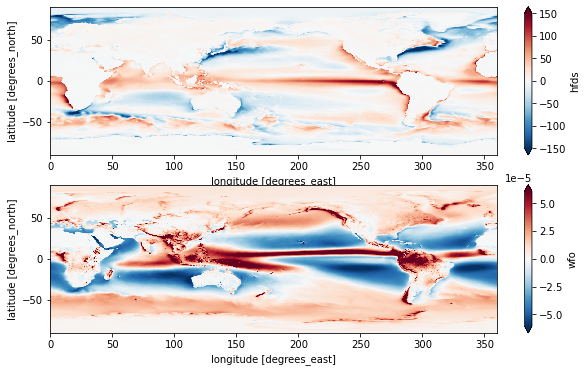

In [57]:
fig,(ax1,ax2) = plt.subplots(figsize=(10,6),nrows=2)
ds_wmt['hfds'].isel(time=slice(-240,-1)).mean('time').plot(ax=ax1,robust=True,vmin=-150,vmax=150,cmap='RdBu_r')
ds_wmt['wfo'].isel(time=slice(-240,-1)).mean('time').plot(ax=ax2,robust=True)

In [58]:
### Get SoS from en4
sos = xr.open_zarr(rootdir_sos+'era5.zarr')['salinity']
sos_wmt = (sos.
           sel(time=ds['time'],method='nearest',drop=True).
           assign_coords(ds.coords).
           chunk({'time':120}))
ds_wmt['sos'] = sos_wmt

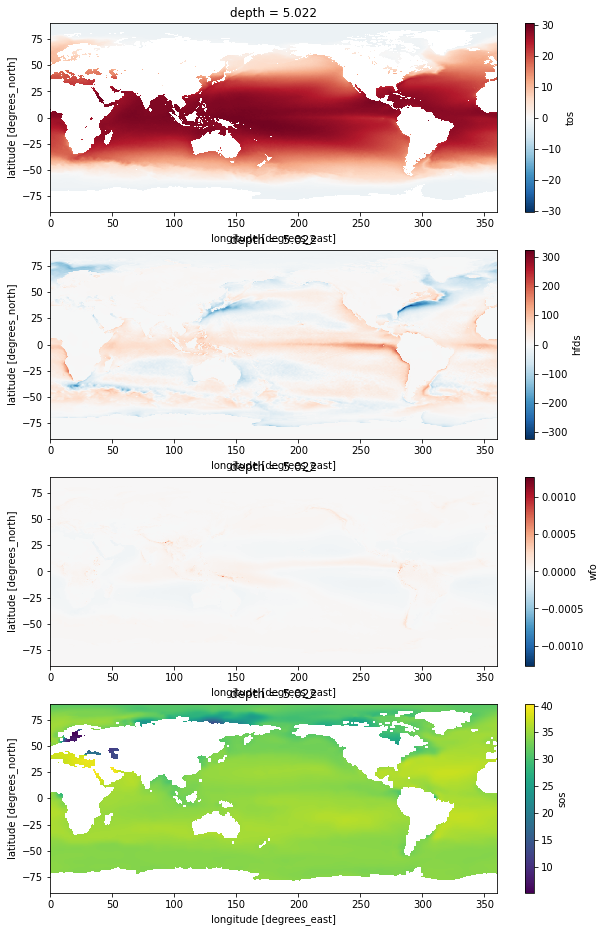

In [59]:
nv = len(ds_wmt.data_vars)
fig,ax = plt.subplots(figsize=(10,4*nv),nrows=nv)
for i,varname in enumerate(ds_wmt.data_vars):
    da = ds_wmt[varname].isel(time=slice(0,120)).mean('time')
    da.plot(ax=ax[i])

In [60]:
with ProgressBar():
    ds_wmt.to_zarr(rootdir_wmt+'era5.en4.ds.zarr',mode='w')

[########################################] | 100% Completed | 120.35 s
